<font size="6"> **Model Building** </font>

Apply advanced Random Forest like models to overcome the issues formerly detected. Decide which methodology is the best performant and fit the champion model

In [1]:
%%capture
%run 04_alphaml_feat_eng.ipynb

In [2]:
MODEL_VERSION = 'v02'
print('Model version: ', MODEL_VERSION)

Model version:  v02


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import ParameterGrid

import pickle

In [4]:
from mle_quant_utils import mle_utils

In [5]:
splits = cfg['models']['alpha_ml']['splits']
split_col = cfg['models']['alpha_ml']['split_col']

In [6]:
OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/" + MODEL_VERSION +"/"
OUTFILE1 = cfg['output']['alpha_factors_ml']['features']
OUTFILE2 = cfg['output']['alpha_factors_ml']['targets']
OUTFILE3 = cfg['output']['alpha_factors_ml']['model']

In [7]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")

# Data Preparation

In [8]:
all_assets = all_factors.index.levels[1].values.tolist()
all_pricing = quant_helper.get_pricing(
    data_portal,
    trading_calendar,
    all_assets,
    factor_start_date,
    universe_end_date)

C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:54: FutureWarning: offset is deprecated. Use freq instead
  end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
C:\Users\manua\Documents\repos\dslab_ai4trading\alpha_factors\mle_quant_utils\quant_helper.py:55: FutureWarning: offset is deprecated. Use freq instead
  start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')


# Data Partitioning

In [9]:
print(return_d_raw)

return_5d_raw


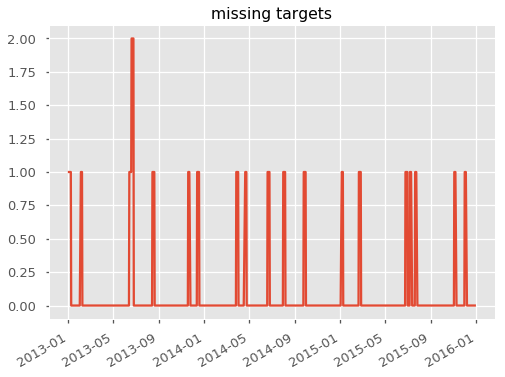

In [10]:
targets_df[return_d_raw].isna().groupby(level=0).sum().plot(title='missing targets', figsize=(8,6));

In [11]:
targets_df[target_col] = targets_df.groupby(level=1)[return_d_raw].shift(-TAU).fillna(0.0)

In [12]:
X_train, X_valid, X_test, y_train, y_valid, y_test = mle_utils.train_valid_test_split(all_factors, targets_df[target_col],
                                                                                      splits['train'], splits['valid'], splits['test'])

In [13]:
(y_train>0).value_counts()

True     122680
False     94269
Name: target, dtype: int64

In [14]:
(y_valid>0).value_counts()

True     40269
False    32349
Name: target, dtype: int64

# Model Building

In [15]:
results = pd.DataFrame(index=['lr_raw', 'rf_raw'],
                       columns=['train_pmean', 'train_score', 'valid_pmean', 'valid_score', 'oob_score'])

In [16]:
factor_names = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed']

In [17]:
n_days = 10
n_stocks = 500
reg_random_state = 123

## Raw Linear Regression

In [114]:
rawlin_reg_parameters = ParameterGrid({
    'fit_intercept': [True],
    'n_jobs': [-1]})

In [115]:
lin_reg_raw = LinearRegression()
lin_raw_models, lin_raw_results = mle_utils.rf_train_val_grid_search(lin_reg_raw, rawlin_reg_parameters, X_train, y_train, X_valid, y_valid, kind='reg')
lin_raw_results.insert(0, 'model',  '01_raw_lin_reg')

Training Models: 100%|██████████| 1/1 [00:01<00:00,  1.34s/Model]


## Rar Ridge Regression

In [120]:
X_train.columns

Index(['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
       'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
       'market_vol_20d', 'volatility_120d', 'volatility_20d', 'is_January',
       'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start',
       'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2',
       'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6',
       'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10',
       'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4'],
      dtype='object')

In [117]:
rawridge_reg_parameters = ParameterGrid({
    'fit_intercept': [False],
    'alpha': [10**x for x in range(-3,5)],
    'random_state': [reg_random_state]})

In [118]:
rid_reg_raw = Ridge()
rid_raw_models, rid_raw_results = mle_utils.rf_train_val_grid_search(rid_reg_raw, rawridge_reg_parameters, X_train, y_train, X_valid, y_valid, kind='reg')
rid_raw_results.insert(0, 'model', '02_raw_ridge')

Training Models: 100%|██████████| 8/8 [00:11<00:00,  1.49s/Model]


## Raw Random Forest

In [22]:
print(features)

['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed', 'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d', 'dispersion_120d', 'dispersion_20d', 'market_vol_120d', 'market_vol_20d', 'volatility_120d', 'volatility_20d', 'is_January', 'is_December', 'month_start', 'month_end', 'qtr_end', 'qtr_start', 'sector_code_-1', 'sector_code_0', 'sector_code_1', 'sector_code_2', 'sector_code_3', 'sector_code_4', 'sector_code_5', 'sector_code_6', 'sector_code_7', 'sector_code_8', 'sector_code_9', 'sector_code_10', 'qtr_1', 'qtr_2', 'qtr_3', 'qtr_4', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']


In [23]:
n_days = np.array([1, 5, 10, 20])
n_stocks = 500

rawrf_reg_parameters = ParameterGrid({
    'min_samples_leaf': n_stocks*n_days,
    'n_estimators': [100],
    'criterion': ['mse'],
    'max_features': [0.5, 0.75, 1.0],
    'oob_score': [True],
    'n_jobs': [-1],
    'random_state': [reg_random_state]})

In [24]:
rf_reg_raw = RandomForestRegressor()
rf_raw_models, rf_raw_results = mle_utils.rf_train_val_grid_search(rf_reg_raw, rawrf_reg_parameters, X_train, y_train, X_valid, y_valid, kind='reg')
rf_raw_results.insert(0, 'model', '03_raw_rf')

Training Models: 100%|██████████| 12/12 [04:46<00:00, 23.87s/Model]


# Benchmarking on Validation

In [116]:
select_cols = ['model', 'alpha', 'n_estimators', 'min_samples_leaf', 'max_features',
        'train_acc', 'train_acc_target<0', 'train_acc_target>0', 'train_pmean', 'train_score', 'oob_score',
        'valid_acc','valid_acc_target<0', 'valid_acc_target>0', 'valid_pmean', 'valid_score']
results_sum_df = pd.concat([lin_raw_results, rid_raw_results, rf_raw_results], axis=0)
results_sum_df.index.name = 'index'
results_sum_df[select_cols].sort_values(by=['model', 'valid_acc', 'valid_acc_target<0'], ascending=False)

,model,alpha,n_estimators,min_samples_leaf,max_features,train_acc,train_acc_target<0,train_acc_target>0,train_pmean,train_score,oob_score,valid_acc,valid_acc_target<0,valid_acc_target>0,valid_pmean,valid_score
index,,,,,,,,,,,,,,,,
8,03_raw_rf,NaN,100.0,500.0,1.00,0.715154,0.604112,0.800481,0.00370671,0.000624123,0.251013,0.551916,0.268973,0.77921,0.008378,0.00100957
3,03_raw_rf,NaN,100.0,10000.0,0.50,0.635006,0.395517,0.819033,0.00371069,0.000767354,0.0853719,0.533862,0.131411,0.857161,0.00563567,0.000884226
6,03_raw_rf,NaN,100.0,5000.0,0.75,0.661473,0.502318,0.783771,0.00370953,0.000734135,0.124499,0.529869,0.405329,0.629914,0.00510642,0.000915567
10,03_raw_rf,NaN,100.0,5000.0,1.00,0.647691,0.489769,0.769041,0.00371054,0.000737622,0.120589,0.528175,0.440725,0.598426,0.00402429,0.000959559
7,03_raw_rf,NaN,100.0,10000.0,0.75,0.639035,0.463249,0.774112,0.00371072,0.000763587,0.0898948,0.524429,0.120251,0.849115,0.00476419,0.000897332
2,03_raw_rf,NaN,100.0,5000.0,0.50,0.661469,0.51178,0.776492,0.00370897,0.000737407,0.12061,0.523438,0.240069,0.751074,0.00578082,0.000894141
4,03_raw_rf,NaN,100.0,500.0,0.75,0.715721,0.606562,0.799601,0.00370653,0.000621223,0.254732,0.523272,0.300195,0.702476,0.00744626,0.000952375
9,03_raw_rf,NaN,100.0,2500.0,1.00,0.668724,0.508216,0.792061,0.00371072,0.000708057,0.155336,0.523011,0.330428,0.677717,0.0058242,0.000996265
0,03_raw_rf,NaN,100.0,500.0,0.50,0.715302,0.602255,0.802168,0.00370572,0.000623522,0.25234,0.522639,0.191165,0.78892,0.00679258,0.000918856


In [26]:
def get_champion(results_df,models_lst, criterion_col = 'valid_score', maximize=True):
    if maximize:
        idx = results_df[criterion_col].astype(float).idxmax()
    else:
        idx = results_df[criterion_col].astype(float).idxmin()
    return models_lst[idx]

In [104]:
selected_lin = get_champion(lin_raw_results, lin_raw_models, criterion_col='valid_acc', maximize=True)
seleted_ridge = get_champion(rid_raw_results, rid_raw_models, criterion_col='valid_acc', maximize=True)
selected_rf = get_champion(rf_raw_results, rf_raw_models, maximize=False)

In [105]:
p_train = y_train.to_frame('y_true')
p_train['linraw_pred'] = selected_lin.predict(X_train)
p_train['ridraw_pred'] = seleted_ridge.predict(X_train)
p_train['ridraw3_pred'] = rid_raw_models[3].predict(X_train)

p_train['rfraw_pred'] =selected_rf.predict(X_train)
p_train['rfraw6_pred'] = rf_raw_models[6].predict(X_train)
p_train['rfraw10_pred'] = rf_raw_models[10].predict(X_train)

p_train['linraw_flg_dir_correct'] = (y_train>0) == (p_train['linraw_pred']>0)
p_train['ridraw_flg_dir_correct'] = (y_train>0) == (p_train['ridraw_pred']>0)
p_train['rfraw_flg_dir_correct'] = (y_train>0) == (p_train['rfraw_pred']>0)


In [106]:
p_valid = y_valid.to_frame('y_true')
p_valid['linraw_pred'] = selected_lin.predict(X_valid)
p_valid['ridraw_pred'] = seleted_ridge.predict(X_valid)
p_valid['ridraw3_pred'] = rid_raw_models[3].predict(X_valid)

p_valid['rfraw_pred'] = selected_rf.predict(X_valid)
p_valid['rfraw6_pred'] = rf_raw_models[6].predict(X_valid)
p_valid['rfraw10_pred'] = rf_raw_models[10].predict(X_valid)

p_valid['linraw_flg_dir_correct'] = (y_valid>0) == (p_valid['linraw_pred']>0)
p_valid['ridraw_flg_dir_correct'] = (y_valid>0) == (p_valid['ridraw_pred']>0)
p_valid['rfraw_flg_dir_correct'] = (y_valid>0) == (p_valid['rfraw_pred']>0)

In [87]:
preds_cols = ['linraw_pred','ridraw_pred',  'rfraw_pred']
diracc_cols = ['linraw_flg_dir_correct', 'ridraw_flg_dir_correct', 'rfraw_flg_dir_correct']

In [88]:
p_train.groupby(p_train['y_true']>0)[preds_cols].describe().T

y_true                    False          True 
linraw_pred count  94269.000000  122680.000000
            mean       0.002434       0.004681
            std        0.005684       0.006172
            min       -0.018156      -0.020115
            25%       -0.001354       0.000353
            50%        0.002176       0.004379
            75%        0.006181       0.008915
            max        0.022205       0.021617
ridraw_pred count  94269.000000  122680.000000
            mean       0.002454       0.004666
            std        0.005631       0.006138
            min       -0.018147      -0.020117
            25%       -0.001350       0.000230
            50%        0.002094       0.004275
            75%        0.006232       0.008884
            max        0.022479       0.021897
rfraw_pred  count  94269.000000  122680.000000
            mean       0.001701       0.005255
            std        0.005691       0.006452
            min       -0.007944      -0.007944
            25%       -0.001258       0.000661
            50%        0.000753       0.004352
            75%        0.004418       0.007845
            max        0.017603       0.017603

In [89]:
p_train[diracc_cols].mean()

linraw_flg_dir_correct    0.578039
ridraw_flg_dir_correct    0.579035
rfraw_flg_dir_correct     0.635006
dtype: float64

In [90]:
p_valid[diracc_cols].mean()

linraw_flg_dir_correct    0.550552
ridraw_flg_dir_correct    0.548927
rfraw_flg_dir_correct     0.533862
dtype: float64

In [91]:
p_train.groupby(p_train['y_true']>0)[diracc_cols].mean().T

y_true,False,True
linraw_flg_dir_correct,0.331339,0.767607
ridraw_flg_dir_correct,0.341088,0.761876
rfraw_flg_dir_correct,0.395517,0.819033


In [92]:
p_valid.groupby(p_valid['y_true']>0)[diracc_cols].mean()

,linraw_flg_dir_correct,ridraw_flg_dir_correct,rfraw_flg_dir_correct
y_true,,,
False,0.143930,0.150267,0.131411
True,0.877201,0.869180,0.857161


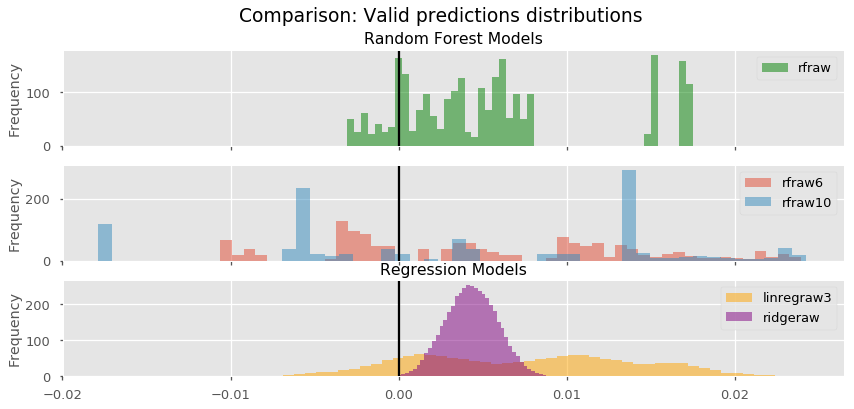

In [113]:
fig, axs = plt.subplots(3,1, sharex=True, figsize=(14, 6))
plt.suptitle('Comparison: Valid predictions distributions')

ax = axs[0]
ax.set_title('Random Forest Models')
p_valid['rfraw_pred'].plot.hist(ax=ax, alpha=0.5, bins=50, density=True, color='green', label='rfraw')
ax.legend()

ax = axs[1]
p_valid['rfraw6_pred'].plot.hist(ax=ax,alpha=0.5, bins=50, density=True, label='rfraw6')
p_valid['rfraw10_pred'].plot.hist(ax=ax,alpha=0.5, bins=50, density=True, label='rfraw10')
ax.legend()

ax = axs[2]
p_valid['ridraw3_pred'].plot.hist(alpha=0.5, bins=50, density=True, color='orange', label='linregraw3', ax=ax)
p_valid['ridraw_pred'].plot.hist(alpha=0.5, bins=50, density=True, color='purple', label='ridgeraw', ax=ax)
ax.legend()
ax.set_title('Regression Models')

for ax in axs:
    ax.axvline(x=0, color='black')
plt.show()

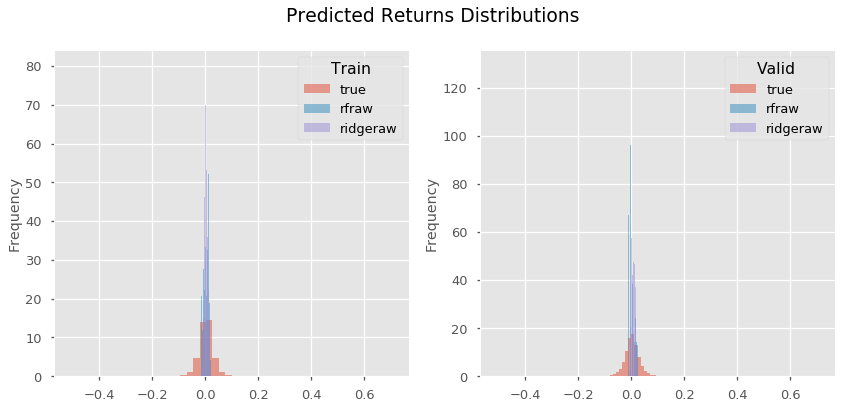

In [36]:
fig, axs = plt.subplots(1,2, sharex=True, figsize=(14, 6))
plt.suptitle('Predicted Returns Distributions')

ax=axs[0]
p_train['y_true'].plot.hist(alpha=0.5, bins=50, density=True, label='true', ax=ax)
p_train['rfraw_pred'].plot.hist(alpha=0.5, bins=50, density=True, label='rfraw', ax=ax)
p_train['ridraw_pred'].plot.hist(alpha=0.5, bins=50, density=True, label='ridgeraw', ax=ax)
#p_train['logregraw_p_prob'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Train')

ax=axs[1]
p_valid['y_true'].plot.hist(alpha=0.5,  bins=50,density=True, label='true', ax=ax)
p_valid['rfraw_pred'].plot.hist(alpha=0.5,  bins=50, density=True, label='rfraw', ax=ax)
p_valid['ridraw_pred'].plot.hist(alpha=0.5,  bins=50, density=True, label='ridgeraw', ax=ax)
#p_valid['logregraw_p_prob'].plot.hist(alpha=0.5, label='logreg', ax=ax)
ax.legend(title='Valid')

plt.show()

Both RF and Rigde models achieves a validation direction accuracy of 55%, however in MSE terms, Ridge models tend to win.

On the other hand, best Rigde models only get upt 15% of negative target accuracy on train dataset while RF models may improve up to 40%

These RF models, that are more balanced, tend to be more regularized hyperparameter tunning configurations, this leads to a quite sparse prediction distribution (less leaves); while Ridge models are continuous, more symmetric when regularization is strong, however it also skews distribution towards positive returns

Achieving a direction accuracy on validation data higher than 50% is a good score, however, in predictive terms, these models display two issues:
* Skewness to positive returns
* Sparse predicted distribution

As the ml-factor takes model predictions but they are re-scaled and ranked this issues are not so serious, computing factor weighted returns will yield extra knownledge.

A final word, this models may be improved by using an ensemble (VotingRegressor) or fine tunning feature engineering process (For example, bucketizing ridge regression features)

# Test Data

As CV is not performed, Test Dataset will be used to constrast validation results, considering only top 3 models, the goal is to honestly assess whether performance metrics are robust or are due to overfitting to validation data by chance

In [143]:
champ_model1 = rf_raw_models[8]
champ_model1_name = "rf_raw8"
champ_model2 = rf_raw_models[6]
champ_model2_name = "rf_raw6"
champ_model3 = rid_raw_models[3]
champ_model3_name = "ridge_raw3"

In [132]:
champ_mod1_refit = RandomForestRegressor().set_params(**champ_model1.get_params())
champ_mod1_refit.fit(pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1.0, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=500, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=123, verbose=0, warm_start=False)

In [133]:
champ_mod2_refit = RandomForestRegressor().set_params(**champ_model2.get_params())
champ_mod2_refit.fit(pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.75, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5000, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=123, verbose=0, warm_start=False)

In [134]:
champ_mod3_refit = Ridge().set_params(**champ_model3.get_params())
champ_mod3_refit.fit(pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0))

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123, solver='auto', tol=0.001)

In [144]:
rename_dict = {"valid_acc": "test_acc",
                "valid_acc_target<0": "test_acc_target<0",
                "valid_acc_target>0": "test_acc_target>0",
                "valid_pmean": "test_pmean",
                "valid_score": "test_score"}

champ_results1 = mle_utils.predict_and_score(champ_mod1_refit,  pd.concat([X_train, X_valid], axis=0),
                                  pd.concat([y_train, y_valid], axis=0),
                                  X_test, y_test, kind='reg').rename(index=rename_dict)
champ_results1.name = champ_model1_name

champ_results2 = mle_utils.predict_and_score(champ_mod2_refit,  pd.concat([X_train, X_valid], axis=0),
                                  pd.concat([y_train, y_valid], axis=0),
                                  X_test, y_test, kind='reg').rename(index=rename_dict)
champ_results2.name = champ_model2_name

champ_results3 = mle_utils.predict_and_score(champ_mod3_refit,  pd.concat([X_train, X_valid], axis=0),
                                  pd.concat([y_train, y_valid], axis=0),
                                  X_test, y_test, kind='reg').rename(index=rename_dict)
champ_results3.name = champ_model3_name

champ_results_lst = [champ_results1, champ_results2, champ_results3]


In [145]:
pd.concat(champ_results_lst, axis=1)

,rf_raw8,rf_raw6,ridge_raw3
oob_score,0.249658,0.124567,NaN
test_acc,0.536961,0.508275,0.490830
test_acc_target<0,0.209299,0.085820,0.125279
test_acc_target>0,0.881007,0.951856,0.874662
test_pmean,0.005658,0.007976,0.009507
test_score,0.001311,0.001353,0.001467
train_acc,0.710647,0.653569,0.576053
train_acc_target<0,0.603058,0.479450,0.329124
train_acc_target>0,0.794249,0.788866,0.767927
train_pmean,0.003572,0.003572,0.003575


This result is very interesting, the most regularized RF model `rf6_raw` is actually overfitting validation data, and when refit and tested on new data, high direction accuracy metrics on taret>0 disappears; this is a disadvantage of the lack of CV, that even regularized models may lead to missleading results.

Both `rf8_raw` and `ridge_raw3` worsen directional accuracy metrics, however it is an expected behaviour.

`rf8_raw` will be selected to be the champion model, achieving a direction accuracy of 53%

In [151]:
champ_mod_refit = champ_mod1_refit

# Write Data

In [146]:
all_factors[split_col] = 'train'
all_factors.loc[X_valid.index, split_col] = 'valid'
all_factors.loc[X_test.index, split_col] = 'test'
all_factors[split_col].value_counts(normalize=True)

train    0.599157
test     0.201185
valid    0.199657
Name: split, dtype: float64

In [147]:
all_factors_cast = quant_helper.cast_zipline_multidx_to_symbol(all_factors[features + [split_col]])
all_factors_cast.to_csv(OUTPATH + OUTFILE1)

In [148]:
targets_df_cast = quant_helper.cast_zipline_multidx_to_symbol(targets_df[[target_col]])
targets_df_cast.to_csv(OUTPATH + OUTFILE2)

In [149]:

results_sum_df[select_cols].to_csv(OUTPATH + 'models_backlog/model_results.csv')

In [150]:
for idx, model in enumerate(lin_raw_models):
    with open(OUTPATH + 'models_backlog/01_raw_lin_reg' + '_' + str(idx) , 'wb') as file:
        pickle.dump(model, file)
for idx, model in enumerate(rid_raw_models):
    with open(OUTPATH + 'models_backlog/02_raw_ridge' + '_' + str(idx) , 'wb') as file:
        pickle.dump(model, file)
for idx, model in enumerate(rf_raw_models):
    with open(OUTPATH + 'models_backlog/03_raw_rf' + '_' + str(idx) , 'wb') as file:
        pickle.dump(model, file)

In [152]:

with open(OUTPATH + OUTFILE3, 'wb') as file:
    pickle.dump(champ_mod_refit, file)